In [ ]:
import zipfile
import glob

# Unzip archive.zip
with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/fingerprints")

print("✅ Dataset extracted.")

# Check total images
all_images = glob.glob("/content/fingerprints/**/*.tif", recursive=True)
print(f"Total images found: {len(all_images)}")


✅ Dataset extracted.
Total images found: 320


STEP 1: PREPROCESSING TO 128 X 128

In [ ]:
import cv2
import numpy as np

# Crop gray borders function
def crop_image_from_gray(img):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    mask = gray > 10
    if mask.any():
        img = img[np.ix_(mask.any(1), mask.any(0))]
    return img

# Full processing
def process_image(path):
    img = cv2.imread(path)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

# Process all images
processed_images = [process_image(p) for p in all_images]
processed_images = np.array(processed_images)
print(f"✅ Processed images shape: {processed_images.shape}")


✅ Processed images shape: (320, 128, 128, 1)


STEP 2: NOISE INJECTION

In [ ]:
def add_noise(image, stage):
    noise_factors = {1: 0.1, 2: 0.2, 3: 0.3, 4: 0.3}
    noise = np.random.normal(0, 1, image.shape)
    noisy_image = image + noise_factors[stage] * noise

    if stage == 4:
        noisy_image = cv2.GaussianBlur(noisy_image.squeeze(), (5, 5), 0)
        noisy_image = np.expand_dims(noisy_image, axis=-1)

    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image

# Apply noise (use stage 3 for training)
noisy_images = [add_noise(img, stage=3) for img in processed_images]
noisy_images = np.array(noisy_images)


STEP 3: DATASET PREPARATION

In [ ]:
import tensorflow as tf

BUFFER_SIZE = len(noisy_images)
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((noisy_images, processed_images))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


STEP 4: U-NET GENERATOR

In [ ]:
from tensorflow.keras import layers, Model

def unet_generator():
    inputs = layers.Input(shape=(128, 128, 1))

    # Encoder
    e1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    e1 = layers.LeakyReLU()(e1)

    e2 = layers.Conv2D(128, 4, strides=2, padding='same')(e1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.LeakyReLU()(e2)

    e3 = layers.Conv2D(256, 4, strides=2, padding='same')(e2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.LeakyReLU()(e3)

    b = layers.Conv2D(512, 4, strides=2, padding='same')(e3)
    b = layers.BatchNormalization()(b)
    b = layers.ReLU()(b)

    d1 = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(b)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Concatenate()([d1, e3])
    d1 = layers.ReLU()(d1)

    d2 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(d1)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Concatenate()([d2, e2])
    d2 = layers.ReLU()(d2)

    d3 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(d2)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Concatenate()([d3, e1])
    d3 = layers.ReLU()(d3)

    outputs = layers.Conv2DTranspose(1, 4, strides=2, padding='same', activation='sigmoid')(d3)
    return Model(inputs, outputs)

generator = unet_generator()
generator.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,088 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    524,544 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,408 │ re_lu[0][0]       │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Concatenate)       │ 512)              │            │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 16, 16,    │          0 │ concatenate[0][0] │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │  1,048,704 │ re_lu_1[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,170,241 (23.54 MB)

 Trainable params: 6,167,553 (23.53 MB)

 Non-trainable params: 2,688 (10.50 KB)

STEP 5 — PatchGAN Discriminator

In [ ]:
def build_discriminator():
    input_noisy = layers.Input(shape=(128, 128, 1))
    input_clean = layers.Input(shape=(128, 128, 1))

    combined = layers.Concatenate()([input_noisy, input_clean])

    d = layers.Conv2D(64, 4, strides=2, padding='same')(combined)
    d = layers.LeakyReLU()(d)

    d = layers.Conv2D(128, 4, strides=2, padding='same')(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU()(d)

    d = layers.Conv2D(256, 4, strides=2, padding='same')(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU()(d)

    d = layers.Conv2D(1, 4, strides=1, padding='same')(d)
    output = layers.Activation('sigmoid')(d)

    return Model([input_noisy, input_clean], output)

discriminator = build_discriminator()
discriminator.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 2)                │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      2,112 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    131,200 │ leaky_re_lu_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    524,544 │ leaky_re_lu_4[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16, 1) │      4,097 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16, 1) │          0 │ conv2d_7[0][0]    │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 663,489 (2.53 MB)

 Trainable params: 662,721 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)

STEP 6 — Losses and Optimizers

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
l1_loss = tf.keras.losses.MeanAbsoluteError()

def generator_loss(disc_output, gen_output, target):
    adv_loss = bce(tf.ones_like(disc_output), disc_output)
    l1 = l1_loss(target, gen_output)
    total_gen_loss = adv_loss + 100 * l1
    return total_gen_loss

def discriminator_loss(disc_real, disc_generated):
    real_loss = bce(tf.ones_like(disc_real), disc_real)
    gen_loss = bce(tf.zeros_like(disc_generated), disc_generated)
    return real_loss + gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


STEP 7 — Training Step

In [ ]:
@tf.function
def train_step(input_noisy, target_clean):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_noisy, training=True)
        disc_real = discriminator([input_noisy, target_clean], training=True)
        disc_generated = discriminator([input_noisy, gen_output], training=True)

        gen_loss = generator_loss(disc_generated, gen_output, target_clean)
        disc_loss = discriminator_loss(disc_real, disc_generated)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss


STEP 8 — Full Training Loop

In [10]:
import time

EPOCHS = 100

for epoch in range(EPOCHS):
    start = time.time()
    gen_losses = []
    disc_losses = []

    for input_noisy_batch, target_clean_batch in train_dataset:
        gen_loss, disc_loss = train_step(input_noisy_batch, target_clean_batch)
        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

    print(f"Epoch {epoch+1}/{EPOCHS} - Gen Loss: {np.mean(gen_losses):.4f} - Disc Loss: {np.mean(disc_losses):.4f} - Time: {time.time()-start:.2f}s")


Epoch 1/100 - Gen Loss: 9.2896 - Disc Loss: 0.9844 - Time: 90.38s
Epoch 2/100 - Gen Loss: 9.0781 - Disc Loss: 1.0219 - Time: 81.81s
Epoch 3/100 - Gen Loss: 8.8679 - Disc Loss: 1.0110 - Time: 80.28s
Epoch 4/100 - Gen Loss: 9.0605 - Disc Loss: 1.0445 - Time: 80.53s
Epoch 5/100 - Gen Loss: 9.2530 - Disc Loss: 1.0834 - Time: 81.40s
Epoch 6/100 - Gen Loss: 9.0286 - Disc Loss: 0.9764 - Time: 81.57s
Epoch 7/100 - Gen Loss: 9.5185 - Disc Loss: 0.9366 - Time: 81.02s
Epoch 8/100 - Gen Loss: 9.6305 - Disc Loss: 1.0622 - Time: 80.86s
Epoch 9/100 - Gen Loss: 8.9282 - Disc Loss: 1.0128 - Time: 80.02s
Epoch 10/100 - Gen Loss: 9.0554 - Disc Loss: 1.0197 - Time: 80.64s
Epoch 11/100 - Gen Loss: 8.7443 - Disc Loss: 1.1899 - Time: 81.20s
Epoch 12/100 - Gen Loss: 9.0158 - Disc Loss: 1.0576 - Time: 80.44s
Epoch 13/100 - Gen Loss: 8.9793 - Disc Loss: 1.0847 - Time: 79.67s
Epoch 14/100 - Gen Loss: 8.9244 - Disc Loss: 1.0191 - Time: 79.56s
Epoch 15/100 - Gen Loss: 8.7621 - Disc Loss: 1.0530 - Time: 80.49s
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


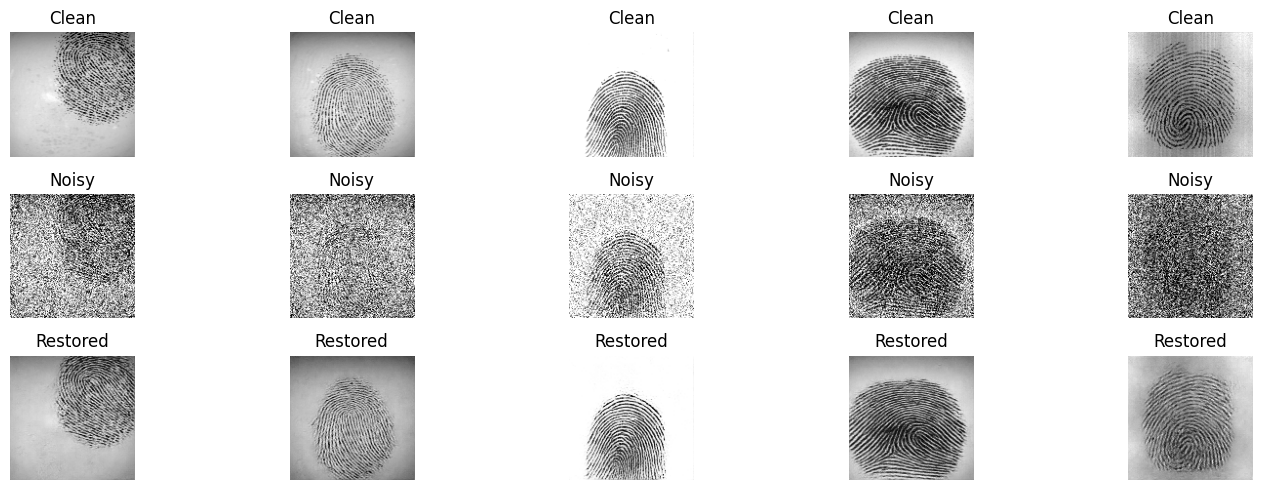

In [11]:
import matplotlib.pyplot as plt
import random

# Pick 5 random test samples
test_idx = random.sample(range(len(processed_images)), 5)
test_clean = processed_images[test_idx]
test_noisy = noisy_images[test_idx]
restored = generator.predict(test_noisy)

plt.figure(figsize=(15, 5))

for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(test_clean[i].squeeze(), cmap='gray')
    plt.title("Clean")
    plt.axis('off')

    plt.subplot(3, 5, i+6)
    plt.imshow(test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    plt.subplot(3, 5, i+11)
    plt.imshow(restored[i].squeeze(), cmap='gray')
    plt.title("Restored")
    plt.axis('off')

plt.tight_layout()
plt.show()
